This notebook shows the validity of the HST transform on a Ising model and tests it against simulation by MCMC. 

In [1]:
!git clone https://github.com/lindamauron/TP-IV
import sys
sys.path.insert(0,'/content/TP-IV')

Cloning into 'TP-IV'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 336 (delta 103), reused 302 (delta 69), pack-reused 0
Receiving objects: 100% (336/336), 16.03 MiB | 20.19 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import MCMC

import itertools
import numpy.linalg

#%matplotlib notebook

import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 5)

try:
    from tqdm.auto import tqdm  # progressbar
except ImportError:
    tqdm = lambda x: x

# Functions and tests

Model : $\mathcal{H} = -\frac{1}{2} \sum_{ij} s_i J_{ij} s_j - \sum_i h_i s_i$
1D chain of length N with periodic bcs : $s_N = s_0$


## Functions

In [3]:
def generate_H(N, beta, h, dim=1):
    return beta*h*np.ones( N**dim )

def generate_NN(N, beta, jnn, dim=1, pbc=True):
    NN = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)

    if pbc : 
        NN[0,N-1] = 1
        NN[N-1,0] = 1
    NN *= jnn

    if dim == 1 : 
        J = NN
    if dim == 2:
        I = np.diag( np.ones(N) )
        J = np.kron(I,NN) + np.kron(NN,I)
    if dim == 3:
        I = np.diag( np.ones(N) )
        J = np.kron(np.kron(I, NN), I) + np.kron(np.kron(NN, I), I) + np.kron(I, np.kron(I,NN))

    K = beta*J + 2.5*dim*beta*np.abs(jnn)*np.diag(np.ones(N**dim))
    return K,J

def generate_NNN(N, beta, jnn, jnnn, dim=1, pbc=True):
    T = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)
    if pbc : 
        T[0,N-1] = 1
        T[N-1,0] = 1

    if dim == 1 : 
        NNN = np.diag(np.ones(N-2), 2) + np.diag(np.ones(N-2), -2)
        if pbc : 
            NNN[0,N-2] = 1
            NNN[N-2,0] = 1
        J = jnn*T + jnnn*NNN
    if dim == 2:
        I = np.diag( np.ones(N) )
        J = jnn*np.kron(I,T) + jnn*np.kron(T,I) + jnnn*np.kron(T,T)
    if dim == 3:
        I = np.diag( np.ones(N) )
        J = jnn*( np.kron(np.kron(I, T), I) + np.kron(np.kron(T, I), I) + np.kron(I, np.kron(I,T)) )
        J += jnnn*( np.kron(np.kron(T, I), T) + np.kron(np.kron(I, T), T) + np.kron(T, np.kron(T,I)) )

    K = beta*J + 6*dim*beta*max(np.abs(jnn),np.abs(jnnn))*np.diag(np.ones(N**dim))
    return K,J

In [4]:
# Log of the unnormalized probability distribution in Eq. (4)
def log_prob(phi):
    # Exponential part
    p = -0.5 * phi.T @ K @ phi
    
    # Product of i part
    x = H + K@phi
    p += np.sum( np.abs(x) + np.log1p(np.exp(-2*np.abs(x))) )
    
        
    return p

def discrete_prob(s):
    '''
    Probability in the spin space
    '''
    return 0.5*beta*s.T @ J_matrix @ s + H@s

In [5]:

def cont_M_array(s):
  m = np.tanh(H[0] + K[0]@s.T )/N
  for i in range(1,N):
    m += np.tanh(H[i] + K[i]@s.T )/N
  return m

def cont_M_mean(s):
  return np.mean(cont_M_array(s))

def discrete_M_array(s):
  return np.mean(s, axis = 1)

def discrete_M_mean(s):
  return np.mean( discrete_M_array(s) )

In [6]:
def variance(g, list_samples):
  Ns = list_samples.shape[0]

  g_moy = np.mean( g(list_samples), axis = 0)
  g_var2 = np.mean( g(list_samples)**2, axis = 0) - g_moy**2

  '''
  for k in range(Ns):
    g_moy += g(list_samples[k])/Ns
    g_var2 += g(list_samples[k])**2 / Ns

  g_var2 -= g_moy**2
  #g_moy = np.mean( g(list_samples), axis=0)
  #g_var2 = np.mean( g(list_samples)**2, axis=0) - g_moy**2
  '''

  A = np.fft.fft(g(list_samples) - g_moy)
  B = A * np.conj(A)
  rho = np.fft.ifft(B) / g_var2

  tao = 0.5 + np.sum(rho.real )

  return np.sqrt(g_var2) * 2 * tao / Ns, tao
                          

## Testing the implementation

Jnn = 1 and Jnnn=0


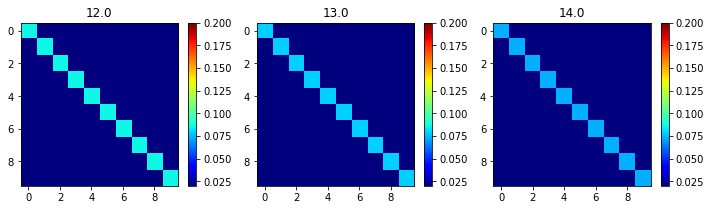

0.08658008658008659 -0.00432900432900433
Jnn = -1 and Jnnn=0


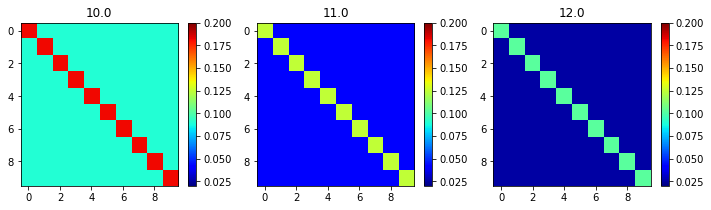

0.18181818181818185 0.02564102564102564


In [ ]:
# verify form of K
for jnn in [1, -1]:
  for jnnn in [0]:
    m = 0
    n = 1000
    #K_test, J = generate_NN(10,beta=1,jnn=jnn,dim=1)
    J = jnn*np.ones((10,10))
    K_test = J + 10*np.diag(np.ones(10))
    print(f'Jnn = {jnn} and Jnnn={jnnn}')
    plt.figure(figsize=(12,3))
    for i in range(3):
      K_test += np.diag(np.ones(10))
      #print(np.linalg.eigvalsh(K_test))
      Kinv = np.linalg.inv(K_test)
      #Kinv[Kinv< 0] = -10
      n = min(n, np.min(Kinv) )
      m = max(m, np.max(Kinv))


      plt.subplot(1,3,i+1)
      img = plt.imshow(Kinv, vmin=0.02, vmax=0.2, cmap='jet', aspect='auto')
      plt.colorbar()
      plt.title(K_test[0,0])
      #plt.savefig(f'covariance_CW={jnn}.png', dpi=200, bbox_inches='tight')
    plt.show()
    print(m,n)



In [ ]:
# Testing eigendecomposition

K_test, J_test = generate_NNN(10,beta=1,jnn=-1,jnnn=1,dim=1)
#print(J_matrix, K_matrix)
values, vectors = np.linalg.eigh(K_test)
print(values)
#J_matrix
#s = np.random.normal(0,1, 2)
#print(f'Initial basis : {s.T @ K_test @ s}')

#print(f'eigenbasis {s.T @ vectors.T @ np.diag(values) @ vectors @ s}')

print(values <= 0)


[3.69951151 4.         4.62028398 5.         5.         5.58578644
 5.83608332 8.         8.41421356 9.84412119]
[False False False False False False False False False False]


In [ ]:
# Verify positive-definiteness
for d in [1]:
    for N in range(2,60):
        K_matrix = generate_NNN(N,beta=1,jnn=-1,jnnn=-1,dim=d, pbc=True)
        values = np.linalg.eigvalsh(K_matrix)

        if (values <= 0).any() : 
            print(f'{d}, {N}, {values[values<=0]}')
            

Tests for diag = 2.5*|J|*d, for up to 80, 60, 15 spins for d=1,2,3 respectively

For j = -1 : 
d = 1,2,3 : None with or without PBC

For j = 1: 
d = 1,2,3 : None with or without PBC

Tested for NN with diag = 6*|max(jnn, jnnn)|*d

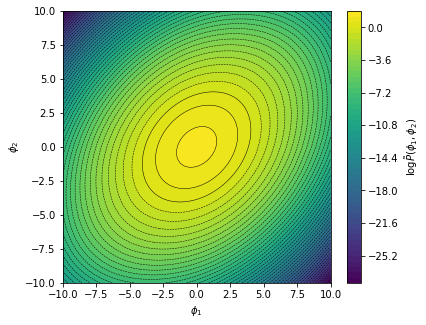

array([-1., -1.])

In [ ]:
# Verify gaussian shape
phi = np.linspace(-10, 10, 101)
#phi1, phi2 = np.meshgrid(phi, phi)

N = 2
beta = 1

jnn = -1
h = 1

K, J_matrix = generate_NN(2,beta=beta, jnn=jnn,dim=1, pbc=True)
H = generate_H(N, beta=beta, h=0)

p = np.zeros( (101,101) )
for k in range(101):
    for j in range(101):
        p[k,j] = log_prob( np.array([phi[k],phi[j]]) )

#p = np.exp(p)


fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.contourf(phi, phi, p, levels=50)
ax.contour(phi, phi, p, levels=50, colors='black', linewidths=.5)

#im = ax.scatter(phi1, phi2,c=p)
cbar = plt.colorbar(im)
cbar.set_label(r'$\log \tilde{P}(\phi_1, \phi_2)$')
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\phi_2$')
#plt.savefig(f'LogDistribution_jnn={jnn}_h={h}.png', dpi=200, bbox_inches='tight')
plt.show()

-numpy.linalg.inv(K)@(K[1]+K[0])

Indices 	 position 	 value
(70, 70) 	 (1.0, 1.0) 	 3.076692384496459
(70, 30) 	 (1.0, -1.0) 	 3.076692384496459
(30, 70) 	 (-1.0, 1.0) 	 3.076692384496459
(30, 30) 	 (-1.0, -1.0) 	 6.750370206569171
(30, 30) 	 (-1.0, -1.0) 	 6.750370206569171


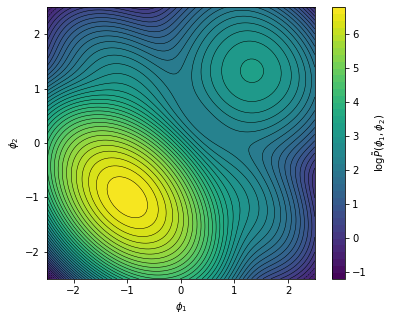

In [ ]:

# Verify gaussian shape
phi = np.linspace(-2.5, 2.5, 101)


N = 3
beta = 1
jnn = 1
h = -0.0

K, J_matrix = generate_NN(N,beta=beta, jnn=jnn,dim=1, pbc=True)
H = generate_H(N, beta=beta, h=h)



phi0 = -1

p = np.zeros( (101,101) )
for k in range(101):
    for j in range(101):
        p[k,j] = log_prob( np.array([phi0,phi[k],phi[j]]) )

print('Indices \t position \t value')



index_p1 = np.argmin(np.abs(phi-1))
index_m1 = np.argmin(np.abs(phi+1))
print(f'{index_p1, index_p1} \t {phi[index_p1], phi[index_p1]} \t {p[index_p1, index_p1]}')
print(f'{index_p1, index_m1} \t {phi[index_p1], phi[index_m1]} \t {p[index_p1, index_m1]}')
print(f'{index_m1, index_p1} \t {phi[index_m1], phi[index_p1]} \t {p[index_m1, index_p1]}')
print(f'{index_m1, index_m1} \t {phi[index_m1], phi[index_m1]} \t {p[index_m1, index_m1]}')

i,j = np.unravel_index(np.argmax(p, axis=None), p.shape)
print(f'{i,j} \t {phi[i], phi[j]} \t {p[i,j]}')

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.contourf(phi, phi, p, levels=50)
ax.contour(phi, phi, p, levels=50, colors='black', linewidths=.5)

#im = ax.scatter(phi1, phi2,c=p)
cbar = plt.colorbar(im)
cbar.set_label(r'$\log \tilde{P}(\phi_1, \phi_2)$')
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\phi_2$')
plt.savefig(f'LogDistribution_jnn={jnn}_h={h}.png', dpi=200, bbox_inches='tight')
plt.show()

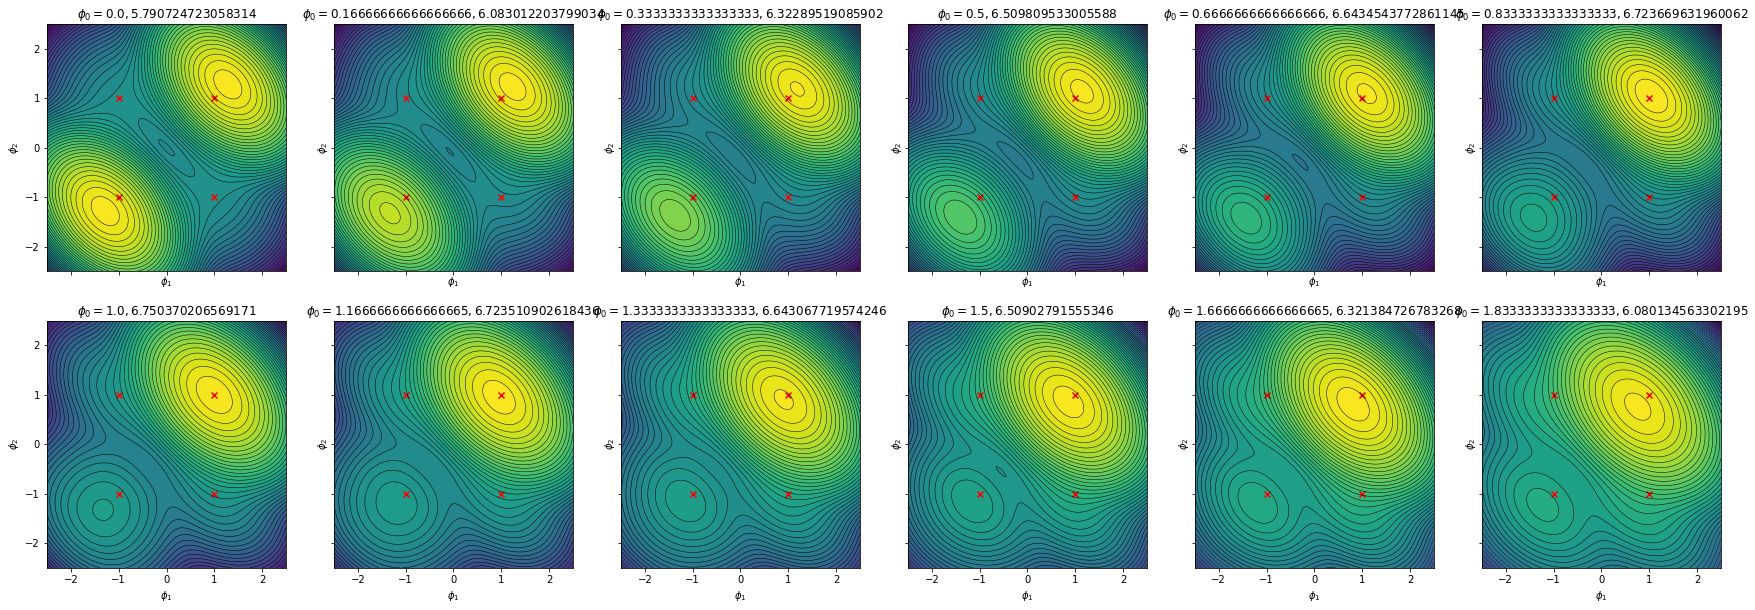

In [ ]:
# Verify positions of peaks
phi = np.linspace(-2.5, 2.5, 101)


N = 3
beta = 1
jnn = 1
h = 0

K, J_matrix = generate_NN(N,beta=beta, jnn=jnn,dim=1, pbc=True)
H = generate_H(N, beta=beta, h=h)


fig, axes = plt.subplots(2,6, figsize=(30,10), sharex=True, sharey=True)
axes = axes.reshape(12)
for i,phi0 in enumerate(np.linspace(0,2,13)[:-1]):
  #l = int(i > 5)
  #m = i - 6*l

  p = np.zeros( (101,101) )
  for k in range(101):
      for j in range(101):
          p[k,j] = log_prob( np.array([phi0,phi[k],phi[j]]) )



  im = axes[i].contourf(phi, phi, p, levels=50)
  axes[i].contour(phi, phi, p, levels=50, colors='black', linewidths=.5)

  #cbar = plt.colorbar(im)
  #cbar.set_label(r'$\log \tilde{P}(\phi_1, \phi_2)$')
  axes[i].set_xlabel('$\phi_1$')
  axes[i].set_ylabel('$\phi_2$')
  axes[i].scatter([-1,-1,1,1], [-1,1,-1,1], color='r', marker='x')
  axes[i].set_title(f'$\phi_0 = {phi0}, {np.max(p)}$')
  #plt.savefig(f'LogDistribution_jnn={jnn}_h={h}.png', dpi=200, bbox_inches='tight')
plt.show()



### Analytical solutions for : 
- Partition function $Z$
- Magnetization $M = \frac{1}{N} \sum_i \langle s_i \rangle$
- Correlation $\langle s_i s_j \rangle$

In [ ]:
def partition_function():
    b = np.exp(beta*J)*np.cosh(beta*h)
    sq = np.sqrt( np.exp(2*beta*J)*np.sinh(beta*h)**2 + np.exp(-2*beta*J) )
    
    l1 = b + sq
    l2 = b - sq
    
    return l1**N + l2**N


def magn():
    b = np.exp(beta*J)*np.cosh(beta*h)
    sq = np.sqrt( np.exp(2*beta*J)*np.sinh(beta*h)**2 + np.exp(-2*beta*J) )
    
    l1 = b + sq
    l2 = b - sq
    
    Z = l1**N + l2**N
    
    db = np.exp(beta*J)*np.sinh(beta*h)
    
    m = (db + 1/sq *np.exp(2*beta*J)*np.sinh(beta*h)*np.cosh(beta*h) ) * l1**(N-1)
    m+= (db - 1/sq *np.exp(2*beta*J)*np.sinh(beta*h)*np.cosh(beta*h) ) * l2**(N-1)
    
    return m/Z

'''
def correlation(i,j):
    b = np.exp(beta*J)*np.cosh(beta*h)
    sq = np.sqrt( np.exp(2*beta*J)*np.sinh(beta*h)**2 + np.exp(-2*beta*J) )
    
    l1 = b + sq
    l2 = b - sq
    
    m = (l1**N + l2**N)*(l1 + l2 -2*np.exp(beta*h+beta*J))**2
    m+= (l1**(N-i+j) * l2**(i-j) + l2**(N-i+j) * l1**(i-j)) * (2*l1 - 2*np.exp(beta*h+beta*J)) * (2*np.exp(beta*h+beta*J) - 2*l2)
    m/= (l1 - l2)**2
    
    return m/(l1**N + l2**N)
'''

def correlation(i,j):
    b = np.exp(beta*J)*np.cosh(beta*h)
    sq = np.sqrt( np.exp(2*beta*J)*np.sinh(beta*h)**2 + np.exp(-2*beta*J) )
    
    l1 = b + sq
    l2 = b - sq
    
    m = np.cosh(beta*h) * (l1**N - l2**N)/sq + N*np.exp(3*beta*J)*np.sinh(beta*h)**2 * (l1**N + l2**N)
    m *= N*np.exp(beta*J)
    m /= 1 + np.exp(4*beta*J)*np.sinh(beta*h)**2
    
    
    return m/(l1**N + l2**N)

In [ ]:
'''
# Test wether m(h) has the right shape
J = 1
h = -0.2
print(magn())
print(magn_derivative())
print(discrete_magnetization(5))

x = np.linspace(-2, 2, 100)
m1 = np.zeros(100)
m2 = np.zeros(100)
m3 = np.zeros(100)

for k in range(100):
    J = x[k]
    m1[k] = magn()
    m2[k] = magn_derivative()
    m3[k] = discrete_magnetization(4)

plt.figure()
#plt.plot(x, m1) # no
plt.plot(x, m2)
#plt.plot(x, m3) # no
plt.legend(range(3))
plt.show()
'''

'\n# Test wether m(h) has the right shape\nJ = 1\nh = -0.2\nprint(magn())\nprint(magn_derivative())\nprint(discrete_magnetization(5))\n\nx = np.linspace(-2, 2, 100)\nm1 = np.zeros(100)\nm2 = np.zeros(100)\nm3 = np.zeros(100)\n\nfor k in range(100):\n    J = x[k]\n    m1[k] = magn()\n    m2[k] = magn_derivative()\n    m3[k] = discrete_magnetization(4)\n\nplt.figure()\n#plt.plot(x, m1) # no\nplt.plot(x, m2)\n#plt.plot(x, m3) # no\nplt.legend(range(3))\nplt.show()\n'

# MCMC

## Single MCMC convergence

In [7]:
N = 5
J = 1
h = 1

beta = 1

K, J_matrix = generate_NN(N,beta=1,jnn=-1,dim=2, pbc=True)
H = generate_H(N**2, beta=beta, h=h)


phi0 = np.random.normal(0, 5, size=N**2)

n_MCMC = int(1e5)
sampler = MCMC.Continuous(std=1.5)
#sampler = MCMC.Multivariate(cov=np.linalg.inv(K))
list_samples = sampler.run(phi0, log_prob, n_MCMC)

s0 = np.random.choice([-1.0, 1.0], N**2 )
discrete_engine = MCMC.Discrete()
discrete_samples = discrete_engine.run(s0, discrete_prob, n_MCMC)

Acceptance rate : 0.37101
Acceptance rate : 0.0981


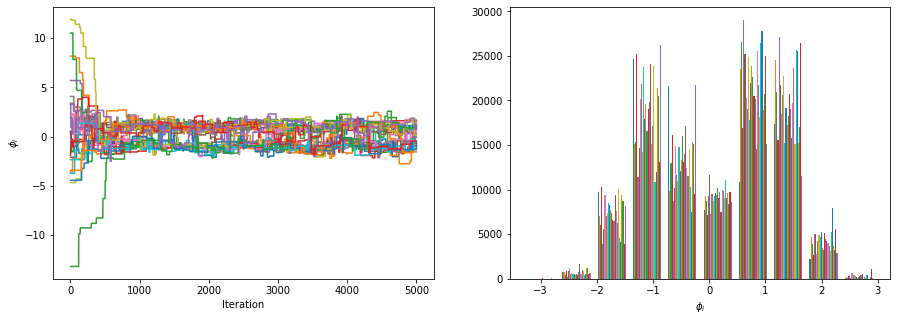

In [ ]:
fig = plt.figure(figsize=(15,5))

# Should show the "convergence" of the MCMC
ax1 = fig.add_subplot(121)
ax1.plot(list_samples[:5000])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\phi_i$')
#ax1.legend(range(N))
#ax1.set_xlim([19000, 20000])
#ax1.set_ylim([-6, 8])


# Should show the wished probability distribution (gaussians for each component)
ax2 = fig.add_subplot(122)
ax2.hist(list_samples[5000:])
ax2.set_xlabel('$\phi_i$')
#ax2.legend(range(N))

#plt.savefig(f'Distribution_J={J}.png', dpi=200, bbox_inches='tight')
plt.show()


In [ ]:
i = 3

# Compute evolution of the magnetization without burning period
m = np.zeros(n_MCMC)
for k in range(n_MCMC):
    m[k:] += np.tanh(H[i] + K[i]@list_samples[k])
    if k > 0:
        m[k] /=  k
    

# Magnetization with burning period   
m_burnt = np.mean( np.tanh(H[i] + K[i]@list_samples[11000:].T), axis=0 )

# Analytical solution of the magnetization
m_th = magn()


# Compare
plt.figure()
plt.hlines(np.abs(m_th), 0, n_MCMC, label='Exact Solution', color='b')
plt.plot(np.abs(m), label='MCMC', color='r')
plt.hlines(np.abs(m_burnt), 0, n_MCMC, label='Thermalized', color='k')
plt.ylabel(r'$M = \frac{1}{N} \sum_i m_i$')
plt.xlabel('MCMC Step')
#plt.ylim([0.9*np.abs(m_burnt), 1.1*np.abs(m_burnt)])
plt.legend()



plt.show()


print(f'Theoretical : {np.abs(m_th)}')
print(f'Obtained : {np.abs(m_burnt)}')

In [ ]:
i = 5
j = 2


corr = np.zeros(n_MCMC)
for k in range(n_MCMC):
    corr[k:] += np.tanh(H[i] + K[i]@list_samples[k]) * np.tanh(H[j] + K[j]@list_samples[k])
    if k > 0:
        corr[k] /=  k

        
c_burnt = np.mean( np.tanh(H[i] + K[i]@list_samples[10000:].T)*np.tanh(H[j] + K[j]@list_samples[10000:].T), axis=0 )
c_th = correlation(i,j)

plt.figure()
plt.hlines(c_th, 0, n_MCMC, label='Exact Solution', color='b')
plt.plot(corr[1000:], label='MCMC', color='r')
plt.hlines(c_burnt, 0, n_MCMC, label='Thermalized', color='k')
plt.xlabel('Spin $i$')
plt.ylabel('MCMC Step')
#plt.ylim([0.9*np.abs(m_burnt), 1.1*np.abs(m_burnt)])
plt.legend()



plt.show()


print(c_burnt)
print(c_th)

## Plots of observables for nearest neighbours

### Simulation

In [ ]:
N = 5
beta = 1
jnn = 1
jnnn = 0

n_MCMC = int(1e6)
phi0 = np.random.normal(0, 5, size=N**2 )
s0 = np.random.choice([-1.0, 1.0], size=N**2 )


nsimuls = 21
#beta_array = np.array([0.1, 0.5, 1, 1.5, 2, 3, 4, 5])
#std = np.array([5, 2.5, 1.4, 1.2, 1, 0.8, 0.7, 0.6])
h_array = np.linspace(0, 4, nsimuls)


list_samples = np.zeros( (nsimuls, n_MCMC, N**2) )
discrete_samples = np.zeros( (nsimuls, n_MCMC, N**2) )
for k in range(nsimuls):
    # Changing parameter
    h = h_array[k]
    
    # Regenerate for correspinding probabilities
    H = generate_H(N, beta=beta, h=h, dim=2)
    K, J_matrix = generate_NN(N,beta=beta,jnn=jnn,dim=2, pbc=True)
    
    # Sample
    sampler = MCMC.Continuous(std = 1.2)
    #sampler = MCMC.Multivariate(cov=np.linalg.inv(K))
    list_samples[k] = sampler.run(phi0, log_prob, n_MCMC)
    
    
    discrete_engine = MCMC.Discrete()
    discrete_samples[k] = discrete_engine.run(s0, discrete_prob, n_MCMC)
    
    '''
    #See walk
    fig = plt.figure(figsize=(8,5))
    plt.title(f'h = {h}')
    
    ax1 = fig.add_subplot(121)
    ax1.plot(list_samples[k,:])
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('$\phi_i$')
    #ax1.legend(range(N))


    ax2 = fig.add_subplot(122)
    ax2.hist(list_samples[k,15000:])
    ax2.set_xlabel('$\phi_i$')
    #ax2.legend(range(N))


    plt.show()
    '''

In [ ]:
T_therm = 2000

for k in range(nsimuls):
    #See walk
    fig = plt.figure(figsize=(15,5))
    #plt.title(f'h = {h}')
    
    ax1 = fig.add_subplot(121)
    ax1.plot(list_samples[k,:2000])
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('$\phi_i$')
    #ax1.legend(range(N))


    ax2 = fig.add_subplot(122)
    ax2.hist(list_samples[k,2000:])
    ax2.set_xlabel('$\phi_i$')
    #ax2.legend(range(N))


    plt.show()


In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt

# save to csv file
for k,h in enumerate(h_array):
  savetxt(f'/content/samples/discrete_samples_j={jnn}_h={h}.csv', discrete_samples[k], delimiter=',')
  savetxt(f'/content/samples/list_samples_j={jnn}_h={h}.csv', list_samples[k], delimiter=',')


In [ ]:
discrete_samples = np.zeros( (nsimuls, n_MCMC, N) )
list_samples = np.zeros( (nsimuls, n_MCMC, N) )

jnn = -1
for k in range(nsimuls):
  discrete_samples[k] = numpy.loadtxt(f'/content/samples/discrete_samples_j={jnn}_h={h_array[k]}.csv', dtype='float', comments='#', delimiter=',')#, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)
  list_samples[k] = numpy.loadtxt(f'/content/samples/list_samples_j={jnn}_h={h_array[k]}.csv', dtype='float', comments='#', delimiter=',')#, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)



### Magnetization

In [ ]:
m_cont = np.zeros(nsimuls)
#m_th = np.zeros(nsimuls)
m_discrete = np.zeros(nsimuls)
err_cont = np.zeros(nsimuls)
err_discrete = np.zeros(nsimuls)
tao_cont = np.zeros(nsimuls)
tao_discrete = np.zeros(nsimuls)
T_therm = 2000


for k in range(nsimuls):
    h = h_array[k]
    H = generate_H(N, beta=beta, h=h, dim=2)
    K, J_matrix = generate_NN(N,beta=beta,jnn=jnn,dim=2, pbc=True)

    m_discrete[k] = discrete_M_mean(discrete_samples[k,T_therm:])
    err_discrete[k], tao_discrete[k] = variance(discrete_M_array, discrete_samples[k,T_therm:])
    m_cont[k] = cont_M_mean(list_samples[k,T_therm:])
    err_cont[k], tao_cont[k] = variance(cont_M_array, list_samples[k,T_therm:] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


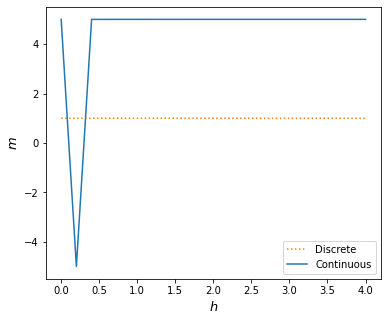

In [ ]:
plt.figure()
#plt.plot(h_array, m_th, label='Theory')
plt.errorbar(h_array, m_cont, label='Continuous')
plt.plot(h_array, m_discrete, label='Discrete', ls=':')
plt.xlabel(r'$h$', fontsize=13)
plt.ylabel(r'$ m $', fontsize=13)
plt.legend()

#plt.title(f'N={N}, Jnn={jnn}', fontsize=13)
#plt.savefig(f'magnetization_jnn={jnn}.png', dpi=200, bbox_inches='tight')
plt.show()

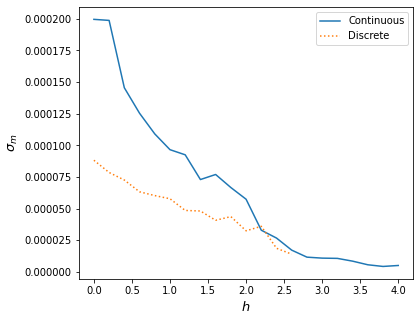

In [ ]:
plt.figure()
#plt.plot(h_array, m_th, label='Theory')
plt.plot(h_array, np.sqrt(err_cont), label='Continuous')
plt.plot(h_array, np.sqrt(err_discrete), label='Discrete', ls=':')
plt.xlabel(r'$h$', fontsize=13)
plt.ylabel(r'$ \sigma_m $', fontsize=13)
plt.legend()

#plt.title(f'N={N}, Jnn={jnn}', fontsize=13)
#plt.savefig(f'error_magnetization_jnn={jnn}.png', dpi=200, bbox_inches='tight')
plt.show()

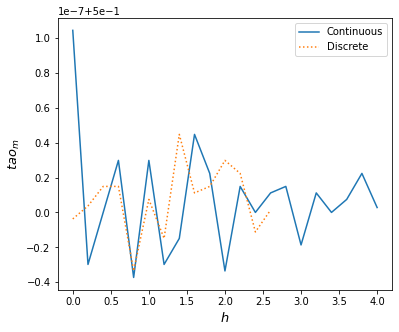

In [ ]:
plt.figure()
#plt.plot(h_array, m_th, label='Theory')
plt.plot(h_array, tao_cont, label='Continuous')
plt.plot(h_array, tao_discrete, label='Discrete', ls=':')
plt.xlabel(r'$h$', fontsize=13)
plt.ylabel(r'$ tao_m $', fontsize=13)
plt.legend()

#plt.title(f'N={N}, Jnn={jnn}', fontsize=13)
#plt.savefig(f'tao_magnetization_jnn={jnn}.png', dpi=200, bbox_inches='tight')
plt.show()

### Correlations

In [ ]:
corr = np.zeros( (N**2-1, nsimuls) )
corr_discrete = np.zeros( (N**2-1, nsimuls) )


for k in range(nsimuls):
    h = h_array[k]
    H = generate_H(N, beta=beta, h=h, dim=2)
    K, J_matrix = generate_NN(N,beta=beta,jnn=jnn,dim=2, pbc=True)

    for i in range(1,N**2):
        corr[i-1,k] = np.mean( np.tanh(H[0] + K[0]@list_samples[k,T_therm:].T)*np.tanh(H[i] + K[i]@list_samples[k,T_therm:].T), axis=0 )
        
        corr_discrete[i-1,k] = np.mean( discrete_samples[k,T_therm:,0] * discrete_samples[k,T_therm:,i] )


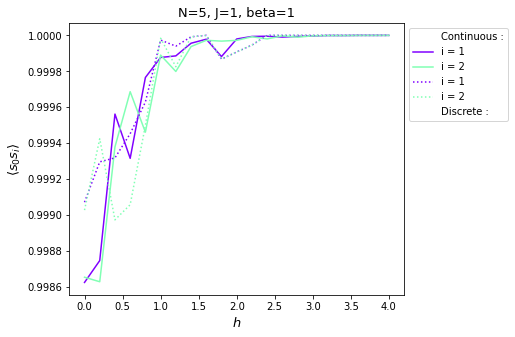

In [ ]:
fig,ax = plt.subplots()
plt.title(f'N={N}, J={jnn}, beta={beta}', fontsize=13)    
color = plt.cm.rainbow(np.linspace(0, 1, int(N/2)+1))
for i,c in zip(range(1,int(N/2)+1), color):
    ax.plot(h_array, corr[i-1], label=f'i = {i}',c=c)
for i,c in zip(range(1,int(N/2)+1), color):
    ax.plot(h_array, corr_discrete[i-1], ls=':',label = f'i = {i}', c=c)
#plt.plot(h_array, corr_th[i-1], label=f'Theory')
ax.set_xlabel(r'$h$', fontsize=13)
ax.set_ylabel(r'$\langle s_0 s_i \rangle $', fontsize=13)

h, l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = [ph[0]] + h[:N-1] + [ph[1]] + h[N-1:]
labels = ["Continuous :"] + l[:N-1] + ["Discrete :"] + l[N-1:]
plt.legend(handles, labels, ncol=1, bbox_to_anchor=(1,1), loc="upper left")

#plt.savefig(f'Correlation_J={jnn}.png', dpi=200, bbox_inches='tight')
plt.show()

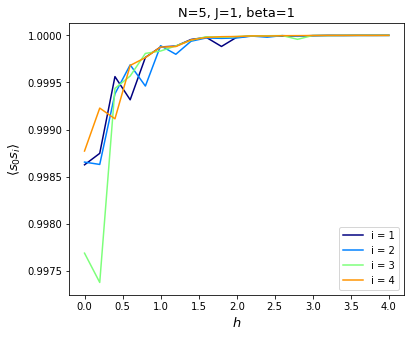

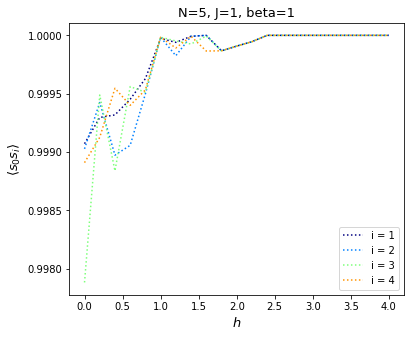

In [ ]:
fig,ax = plt.subplots()
plt.title(f'N={N}, J={jnn}, beta={beta}', fontsize=13)    
color = plt.cm.jet(np.linspace(0, 1, N) )
for i,c in zip(range(1,N), color):
    ax.plot(h_array, corr[i-1], label=f'i = {i}',c=c)
ax.set_xlabel(r'$h$', fontsize=13)
ax.set_ylabel(r'$\langle s_0 s_i \rangle $', fontsize=13)
plt.legend()


fig,ax = plt.subplots()
plt.title(f'N={N}, J={jnn}, beta={beta}', fontsize=13)
for i,c in zip(range(1,N), color):
    ax.plot(h_array, corr_discrete[i-1], ls=':',label = f'i = {i}', c=c)
#plt.plot(h_array, corr_th[i-1], label=f'Theory')
ax.set_xlabel(r'$h$', fontsize=13)
ax.set_ylabel(r'$\langle s_0 s_i \rangle $', fontsize=13)
plt.legend()

'''
h, l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = [ph[0]] + h[:N-1] + [ph[1]] + h[N-1:]
labels = ["Continuous :"] + l[:N-1] + ["Discrete :"] + l[N-1:]
plt.legend(handles, labels, ncol=1, bbox_to_anchor=(1,1), loc="upper left")
'''

#plt.savefig(f'Correlation_J={jnn}.png', dpi=200, bbox_inches='tight')
plt.show()

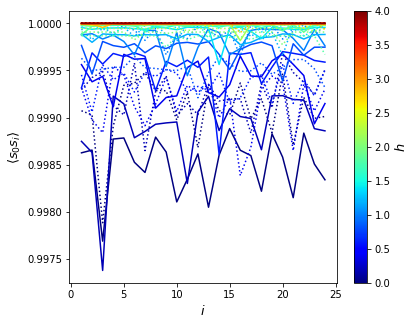

In [ ]:
import matplotlib as mpl

fig,ax = plt.subplots()
#plt.title(f'N={N}, J={jnn}, beta={beta}', fontsize=13)    

cmap = mpl.cm.jet
color = cmap(np.linspace(0, 1, nsimuls) )


for i,c in zip(range(nsimuls), color):
    ax.plot(range(1,N**2), corr[:,i], label=f'h = {h_array[i]}',c=c)
    ax.plot(range(1,N**2), corr_discrete[:,i], ls=':',label = f'h = {h_array[i]}', c=c)
ax.set_xlabel(r'$i$', fontsize=13)
ax.set_ylabel(r'$\langle s_0 s_i \rangle $', fontsize=13)
#plt.legend(ncol=1, bbox_to_anchor=(1,1), loc="upper left")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=4))
cbar = plt.colorbar(sm)
cbar.set_label(r'$h$', fontsize=13)


plt.savefig(f'correlation_jnn={jnn}.png', dpi=200, bbox_inches='tight')
plt.show()

# Observables for second neighbours

In [ ]:
N = 10
beta = 0.1
jnn = 1
jnnn = 1

n_MCMC = int(1e5)
phi0 = np.random.normal(0, 5, size=N)
s0 = np.random.choice([-1.0, 1.0], size=N )


#K, J_matrix = generate_NNN(N,beta=beta,jnn=jnn, jnnn=jnnn, dim=1, pbc=True)

J_matrix = np.ones((N,N));
K0 = J_matrix + 0.5*(N+1)*np.diag(np.ones(N))

nsimuls = 15
#beta_array = np.array([0.1, 0.5, 1, 1.5, 2, 3, 4, 5])
#std = np.array([5, 2.5, 1.4, 1.2, 1, 0.8, 0.7, 0.6])
h_array = np.linspace(0, 7, nsimuls)

list_samples = np.zeros( (3,nsimuls, n_MCMC, N) )
discrete_samples = np.zeros( (3,nsimuls, n_MCMC, N) )

sampler = MCMC.Continuous(std = 1.1)
discrete_engine = MCMC.Discrete()
for i,beta in enumerate([0.5,0.25,0.1]):
  K = beta*K0
  for k in tqdm(range(nsimuls)):
      # Changing parameter
      h = h_array[k]
      
      # Regenerate for correspinding probabilities
      H = generate_H(N, beta=beta, h=h)
      #K, J_matrix = generate_NNN(N,beta=beta,jnn=jnn, jnnn=jnnn, dim=1, pbc=True)
      
      # Sample
      #sampler = MCMC.Multivariate(cov=np.linalg.inv(K))
      list_samples[i,k] = sampler.run(phi0, log_prob, n_MCMC)
      discrete_samples[i,k] = discrete_engine.run(s0, discrete_prob, n_MCMC)


In [ ]:
T_therm = 2000

for k in range(nsimuls):
    #See walk
    fig = plt.figure(figsize=(15,5))
    #plt.title(f'h = {h}')
    
    ax1 = fig.add_subplot(121)
    ax1.plot(list_samples[k,:1000])
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('$\phi_i$')
    #ax1.legend(range(N))


    ax2 = fig.add_subplot(122)
    ax2.hist(list_samples[k,2000:])
    ax2.set_xlabel('$\phi_i$')
    #ax2.legend(range(N))


    plt.show()


In [ ]:
m_cont = np.zeros((3,nsimuls))
#m_th = np.zeros(nsimuls)
m_discrete = np.zeros( (3,nsimuls))
err_cont = np.zeros(nsimuls)
err_discrete = np.zeros(nsimuls)
T_therm = 2000

for i,beta in enumerate([0.5,0.25,0.1]):
  K = K0*beta
  for k in range(nsimuls):
      h = h_array[k]
      H = generate_H(N, beta=beta, h=h)
      #K, J_matrix = generate_NNN(N,beta=beta,jnn=jnn,jnnn=jnnn,dim=1, pbc=True)

      m_discrete[i,k] = discrete_M_mean(discrete_samples[i,k,T_therm:])
      #err_discrete[k], tao = variance(discrete_M_array, discrete_samples[k,T_therm:])
      m_cont[i,k] = cont_M_mean(list_samples[i,k,T_therm:])
      #err_cont[k], tao = variance(cont_M_array, list_samples[k,T_therm:] )

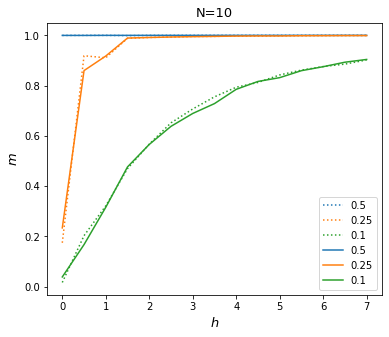

In [ ]:
plt.figure()
for i,beta in enumerate([0.5,0.25,0.1]):
  #plt.plot(h_array, m_th, label='Theory')
  plt.errorbar(h_array, np.abs(m_cont[i]), label=beta, color=f'C{i}')
  plt.plot(h_array, np.abs(m_discrete[i]), label=beta, ls=':', color=f'C{i}')
plt.xlabel(r'$h$', fontsize=13)
plt.ylabel(r'$ m $', fontsize=13)
#plt.ylim([-0.05,1.05])

plt.legend()

plt.title(f'N={N}', fontsize=13)
plt.savefig(f'magnetization_CW_betas.png', dpi=200, bbox_inches='tight')
plt.show()



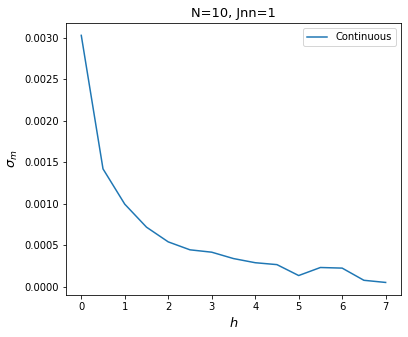

In [ ]:
plt.figure()
#plt.plot(h_array, m_th, label='Theory')
plt.plot(h_array, np.sqrt(err_cont), label='Continuous')
#plt.plot(h_array, np.sqrt(err_discrete), label='Discrete', ls=':')
plt.xlabel(r'$h$', fontsize=13)
plt.ylabel(r'$ \sigma_m $', fontsize=13)
plt.legend()

plt.title(f'N={N}, Jnn={jnn}', fontsize=13)
#plt.savefig(f'error_magnetization_jnn={jnn}_jnnn={jnnn}.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
corr = np.zeros( (N-1, nsimuls) )
corr_discrete = np.zeros( (N-1, nsimuls) )


for k in range(nsimuls):
    h = h_array[k]
    H = generate_H(N, beta=beta, h=h)
    #K, J_matrix = generate_NNN(N,beta=beta,jnn=jnn,jnnn=jnnn,dim=1, pbc=True)

    for i in range(1,N):
        corr[i-1,k] = np.mean( np.tanh(H[0] + K[0]@list_samples[k,T_therm:].T)*np.tanh(H[i] + K[i]@list_samples[k,T_therm:].T), axis=0 )
        
        corr_discrete[i-1,k] = np.mean( discrete_samples[k,T_therm:,0] * discrete_samples[k,T_therm:,i] )


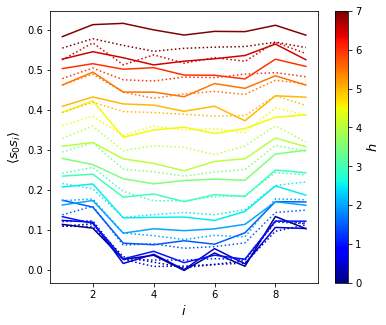

In [ ]:
import matplotlib as mpl

fig,ax = plt.subplots()
#plt.title(f'N={N}, J={jnn}, beta={beta}', fontsize=13)    

cmap = mpl.cm.jet
color = cmap(np.linspace(0, 1, nsimuls) )


for i,c in zip(range(nsimuls), color):
    ax.plot(range(1,N), corr[:,i], label=f'h = {h_array[i]}',c=c)
    ax.plot(range(1,N), corr_discrete[:,i], ls=':',label = f'h = {h_array[i]}', c=c)
ax.set_xlabel(r'$i$', fontsize=13)
ax.set_ylabel(r'$\langle s_0 s_i \rangle $', fontsize=13)
#ax.set_ylim([-0.05, 1.05])
#plt.legend(ncol=1, bbox_to_anchor=(1,1), loc="upper left")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(h_array)))
cbar = plt.colorbar(sm)
cbar.set_label(r'$h$', fontsize=13)


#plt.savefig(f'correlation_jnn={jnn}_jnnn={jnnn}.png', dpi=200, bbox_inches='tight')
plt.show()